# Recommendations with IBM

In this notebook, a recommendation engine will be built to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Using the dictionary and cells below provides some insight into the descriptive statistics of the data.

1. What is the distribution of how many articles a user interacts with in the dataset? Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.


In [4]:
df['article_id'] = df['article_id'].astype(str)
df_content['article_id'] = df_content['article_id'].astype(str)

In [5]:
users_per_article = df.groupby(['article_id']).count()['email'].sort_values(ascending=False)
users_per_article.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [6]:
#users_per_article[:15]

In [7]:
users_per_article.size

714

In [8]:
num_articles_per_user = df.groupby(['email']).count()['article_id'].sort_values(ascending=False)
num_articles_per_user.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

In [9]:
type(num_articles_per_user)

pandas.core.series.Series

In [10]:
df.shape

(45993, 3)

In [11]:
df_content.shape

(1056, 5)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [13]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null object
dtypes: object(5)
memory usage: 41.3+ KB


In [14]:
df.describe()

,article_id,title,email
count,45993,45993,45976
unique,714,714,5148
top,1429.0,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,937,937,364


In [15]:
df_content.describe()

,doc_body,doc_description,doc_full_name,doc_status,article_id
count,1042,1053,1056,1056,1056
unique,1036,1022,1051,1,1051
top,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Here’s this week’s news in Data Science and Bi...,Using Apache Spark as a parallel processing fr...,Live,577
freq,4,16,2,1056,2


In [16]:
num_articles_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

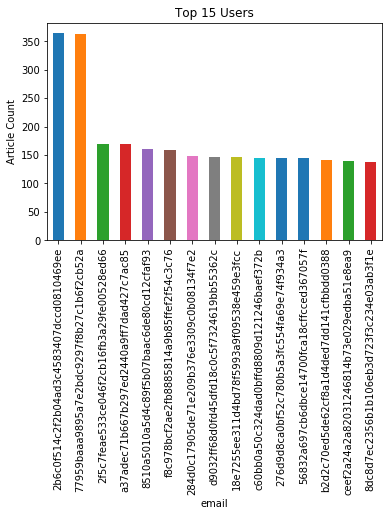

In [17]:
num_articles_per_user[:15].plot(kind='bar');
plt.ylabel('Article Count');
plt.title('Top 15 Users');


In [18]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

2. Explore and remove duplicate articles from the df_content dataframe.

Explore and remove duplicate articles from the **df_content** dataframe.  

In [19]:
df_content.drop_duplicates(subset = ['article_id']).head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [20]:
df_content['article_id'].nunique()

1051

3. Use the cells below to find:

a. The number of unique articles that have an interaction with a user.
b. The number of unique articles in the dataset (whether they have any interactions or not).
c. The number of unique users in the dataset. (excluding null values)
d. The number of user-article interactions in the dataset.

The number of unique articles that have an interaction with a user:

In [21]:
df['article_id'].nunique()


714

In [22]:
for i in df.columns:
    print(i, " ", df[i].nunique())

article_id   714
title   714
email   5148


The number of unique users in the dataset. (excluding null values)

In [23]:
df['email'].nunique(dropna=True)

5148

In [24]:
for i in df_content.columns:
    print(i, " ", df_content[i].nunique())

doc_body   1036
doc_description   1022
doc_full_name   1051
doc_status   1
article_id   1051


In [25]:
df.shape[0]

45993

In [26]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique(dropna=True) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

4. Using the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

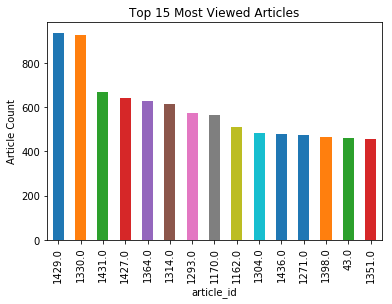

In [27]:
users_per_article[:15].plot(kind='bar');
plt.ylabel('Article Count');
plt.title('Top 15 Most Viewed Articles');


In [28]:
users_per_article.index[0]

'1429.0'

In [29]:
users_per_article.iloc[0]

937

In [30]:
most_viewed_article_id = users_per_article.index[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = users_per_article.iloc[0] # The most viewed article in the dataset was viewed how many times?

In [31]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [32]:
df[df['user_id']==30]

,article_id,title,user_id
40,1164.0,analyze open data sets with pandas dataframes,30
462,33.0,using brunel in ipython/jupyter notebooks,30
611,299.0,brunel in jupyter,30
19362,1313.0,health insurance (2015): united states demogra...,30
19375,732.0,rapidly build machine learning flows with dsx,30


In [33]:
X = df.groupby(['user_id']).count()['article_id'].sort_values(ascending=False)
X.head()

user_id
23      364
3782    363
98      170
3764    169
203     160
Name: article_id, dtype: int64

In [34]:
X = pd.DataFrame(X)
X.head()

,article_id
user_id,
23,364
3782,363
98,170
3764,169
203,160


In [35]:
X[X.index ==23]

,article_id
user_id,
23,364


In [36]:
indexes = X.index.unique()

In [37]:
df.describe()

,user_id
count,45993.000000
mean,2300.918314
std,1712.658385
min,1.000000
25%,621.000000
50%,2330.000000
75%,3835.000000
max,5149.000000


In [38]:
df['user_id'].nunique()

5149

In [39]:
user_stats = df.groupby(['user_id']).count()['article_id'].sort_values(ascending=False)
user_stats.head()

user_id
23      364
3782    363
98      170
3764    169
203     160
Name: article_id, dtype: int64

In [40]:
user_stats.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [41]:
users_per_article.nunique()

195

In [42]:
users_per_article.tail()

article_id
1092.0    1
1266.0    1
1072.0    1
1233.0    1
1200.0    1
Name: email, dtype: int64

In [43]:
df['article_id'].nunique()

714

In [44]:
df['user_id'].nunique()

5149

In [45]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}


# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

The dataframes don't actually have ratings for whether a user liked an article or not, only if a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In the step a function is created to return the **n** top articles ordered with most interactions as the top. 

In [46]:
articles = df['article_id'].value_counts().sort_values(ascending = False)
articles.head()


1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [47]:
top_articles = list(articles.index[:10])
top_articles

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [48]:
top_articles = list(articles.index[:10])
top_articles = df[df['article_id'].isin(top_articles)]['title']
top_articles.unique().tolist()

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [49]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    articles = df['article_id'].value_counts().sort_values(ascending = False)
    top_articles = list(articles.index[:n])
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique().tolist()
    
    
    # Your code here
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    articles = df['article_id'].value_counts().sort_values(ascending = False)
    top_articles = list(articles.index[:n])
    

    return top_articles # Return the top article ids

In [50]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [51]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Here a function below is created to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [52]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [53]:
# df['category']=df['age'].apply(lambda x: 'Adult' if x>=18 else 'Child')
df['indicator'] = df['title'].apply(lambda x: 1)

In [54]:
df.head()

,article_id,title,user_id,indicator
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [55]:
df.drop(['title'], axis =1).head()

,article_id,user_id,indicator
0,1430.0,1,1
1,1314.0,2,1
2,1429.0,3,1
3,1338.0,4,1
4,1276.0,5,1


In [56]:
df_pivot = pd.pivot_table(df, values="indicator", index=["user_id"], columns=["article_id"])
#df_pivot

In [57]:
#df_pivot.fillna(0)

In [58]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df['indicator'] = df['title'].apply(lambda x: 1)
    df.drop(['title'], axis =1).head()
    df_pivot = pd.pivot_table(df, values="indicator", index=["user_id"], columns=["article_id"])
    user_item = df_pivot.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [59]:
#user_item

In [60]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")


You have passed our quick tests!  Please proceed!


In [61]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
 user_item.shape[0] , user_item.shape[1]

(5149, 714)

2. Next, a function is created that will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 


In [63]:
user_item_T = np.transpose(user_item)

In [64]:
user_id_series = np.array(user_item.index)

In [65]:
dot_prod_users = user_item.dot(np.transpose(user_item))

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    user_id_series = np.array(user_item.index)
    user_row = np.where( user_id_series == user_id)[0][0]
    
    # compute similarity of each user to the provided user
    
    similarity = user_item.iloc[user_row,:].dot(np.transpose(user_item))
    
    # sort by similarity
    
    sorted_users = similarity.sort_values(ascending = False)
    
    # remove the own user's id
    
    sorted_users = sorted_users[sorted_users.index != user_id]
    
    # create list of just the ids
    
    similarity_ids = sorted_users.index
       
    # return most_similar_users # return a list of the users in order from most to least similar
    
    return list(similarity_ids)

In [66]:
(find_similar_users(3933)[:5])

[1, 23, 3782, 4459, 203]

In [67]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


3. Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend. Complete the functions below to return the articles you would recommend to each user.



Now that there is a function that provides the most similar users to each user, use these users to find articles to recommend!

In [68]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    articles = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    
    return articles # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    user_row = user_item[user_item.index == user_id] # get the user row!
    
    series1 = user_row.iloc[0,:]
    articles_interacted = series1[series1 == 1] # retrieves articles id's and the integer 1
    
    article_ids = list(articles_interacted.index)
    
    article_names =  df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
   
    
    return article_ids, article_names # return the article ids and names

def user_user_recs(user_id, m=10):
    
    # Your code here
    user_seen = get_user_articles(user_id) # get articles the user has seen. 
    
    like_users = find_similar_users(user_id)[:5] # get 5 users that have similar taste to the user_id
    
    new_recs = []
    
    for user in like_users:
        recs = get_user_articles(user) # get the article id's and names that the 'user' has read!
        new_titles = recs[1] # get just the titles from the tuple, not the article_id
        
        for x in new_titles:
            
            if x not in new_recs and x not in user_seen[1]:
                new_recs.append(x)
    
    return new_recs[:m] 

In [69]:
user_user_recs(10)

['ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'the unit commitment problem',
 'the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'data science for real-time streaming analytics',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'analyze open data sets with pandas dataframes']

In [69]:
get_user_articles(5)


(['1166.0', '1276.0', '1351.0'],
 ['deploy your python model as a restful api',
  'model bike sharing data with spss',
  'analyzing data by using the sparkling.data library features'])

In [70]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


4. Next, improve the consistency of the user_user_recs function from above.

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [71]:
df.head()

,article_id,title,user_id,indicator
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [70]:
import random

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    user_id_series = np.array(user_item.index) # get the user_ids as an array
    
    user_row = np.where( user_id_series == user_id)[0][0] # get the row belonging to the user
    
    num_interactions = user_item.sum(axis =1).sort_values(ascending = False) # get the most active readers in the dataframe
    
    neighborhood_id = num_interactions.index # get the id's of the most active users

    
    
    # compute similarity of each user to the provided user
    
    similarity = []
    
    for n in neighborhood_id:
        
        #user = user_item.iloc[n,:]
        
        other_user_row = np.where( user_id_series == n)[0][0]
        
        sim = user_item.iloc[user_row,:].dot(user_item.iloc[other_user_row,:])
        
        similarity.append(sim)

    neighbors_df = pd.DataFrame(list(zip(neighborhood_id, similarity, num_interactions,)), columns = ['neighborhood_id','similarity','num_interactions'])
    
    
    neighbors_df.index = neighborhood_id  
    
    neighbors_df = neighbors_df[neighbors_df['neighborhood_id'] != user_id ] # drop the user_id from the dataframe!
    
    neighbors_df = neighbors_df.sort_values(["similarity","num_interactions","neighborhood_id"], ascending = False)
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    user_seen = get_user_articles(user_id)
    
    similar_5_users = get_top_sorted_users(user_id)[:5] # a data frame that only contains 5 users information
    
    id_5_users = list(similar_5_users['neighborhood_id']) # get the 5 most similar user_ids!
    
    recommended_titles = [] # create empty list to hold recommended titles!
    
    recommended_title_ids = []
    
    for i in id_5_users:
        
        #i_user_titles = list(df[df['user_id'] == i]['title'])
        #article_ids = list(df[df['user_id'] == i]['article_id'])
        
        i_user_titles = list(df[df['user_id'] == i]['title'])
        
        for x in i_user_titles:
            
            if x not in recommended_titles and x not in user_seen[1]: # avoid duplicates and articles the user already read
                
                recommended_titles.append(x)
                
    # next choose n random titles from the 'recommended_titles' list!
    
    rec_names = random.sample(recommended_titles, m)
    
    # Get the article id's of each of the m recommended titles!
    
    recs = []
    
    for k in rec_names:
        
        id_recs = df[df['title'] == k]['article_id'].iloc[0]
        
        recs.append(id_recs)

    return recs, rec_names 

In [71]:
 get_top_sorted_users(131).iloc[0:18]

,neighborhood_id,similarity,num_interactions
user_id,,,
3870,3870,74.0,75.0
3782,3782,39.0,135.0
23,23,38.0,135.0
4459,4459,33.0,96.0
203,203,33.0,96.0
49,49,29.0,101.0
3697,3697,29.0,100.0
3764,3764,29.0,97.0
98,98,29.0,97.0


In [72]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1426.0', '205.0', '33.0', '1160.0', '1150.0', '1431.0', '681.0', '1278.0', '1324.0', '903.0']

The top 10 recommendations for user 20 are the following article names:
['use spark for scala to load data and run sql queries', "a beginner's guide to variational methods", 'using brunel in ipython/jupyter notebooks', 'analyze accident reports on amazon emr spark', 'airbnb data for analytics: venice calendar', 'visualize car data with brunel', 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)', 'develop a scala spark model on chicago building violations', 'ibm watson facebook posts for 2015', 'an attempt to understand boosting algorithm(s)']


In [73]:
find_similar_users(1)[0]

3933

In [74]:
int(find_similar_users(131)[9])

242

In [75]:
### Tests with a dictionary of results

user1_most_sim = int(find_similar_users(1)[1]) # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [76]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': 3933, 
    'The user that is the 10th most similar to user 131': 242,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


6. If we were given a new user, which of the above functions would you be able to use to make recommendations? Explain. Can you think of a better way we might make recommendations? Use the cell below to explain a better method for new users.

I suppose I would use get_top_article_ids because this function gives the most popular articles. Perhaps if we had more user information such as knowing what areas of IT they are most interested in we could better filter these recommendations. 

7. Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below. You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [77]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [78]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook matrix factorization is used to make article recommendations to the users on the IBM Watson Studio platform.

In [79]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [80]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the next step Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix and the SVD matrices will be used to make predictions for user interactions. 

In [81]:
# Perform SVD on the User-Item Matrix 

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=0)# use the built in to get the three matrices

2. In this situation, you can use Singular Value Decomposition from numpy on the user-item matrix. Use the cell to perform SVD, and explain why this is different than in the lesson.

Provide response here:

In the lesson FUNK SVD was implemented because this was a non-classificaiton based recommender. For each user it was essential that there was a score between values of 1-10 for each movie in the columns, the empty cells were replaced using gradient descent machine learning techniques to better ascertain the analytical aspects of the user matrix. In this project the user matrix is more of a classification based one, where each article column value is a 0 or 1 for each of the users provided. In this case it would not be useful to implement FUNK SVD. 

Now for the tricky part, what is best number of latent features to use?  Running the below cell, this shows that as the number of latent features increases a lower error rate on making predictions for the 1 and 0 values in the user-item matrix is obtained.  

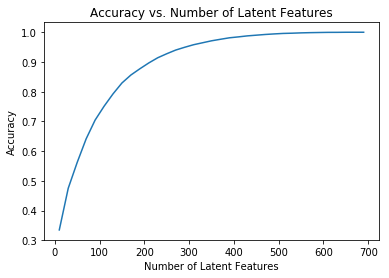

In [82]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From above, it is still not very sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give an indication of if recommendations were good or not.  Instead, split the dataset into a training and test set of data done below.

Some key questions to ask are the following:

* How many users can predictions be made for in the test set?  
* How many users can predictions not be made for because of the cold start problem?
* How many articles can predictions be made for in the test set?  
* How many articles can predictions not be made for because of the cold start problem?

In [83]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    # create user_item matrix into test and train
    user_item_train = create_user_item_matrix(df_train)   
    user_item_test = create_user_item_matrix(df_test)
    
    # all test user ids
    test_idx = user_item_test.index.values
        
    # get all unique test article ids
    test_arts = user_item_test.columns.values
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [84]:
user_item_train.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# set(user_item_train.index).intersection(user_item_test.index)

In [86]:
# common users for both test and training sets:
common_user_item_test = user_item_train[user_item_train.index.isin(user_item_test.index)]

# common articles in both the training and test sets:
common_user_item_test_articles = common_user_item_test.loc[:,user_item_train.columns.isin(user_item_test.columns)]


'How many predictions could not be made for users in the test set because of the cold start problem?'

In [87]:
(user_item_test.shape[0] - common_user_item_test.shape[0])#662 


662

How many articles can predictions be made for  in the test set?

In [88]:
user_item_test.shape[1]

574

How many users can predictions be made for in the test set?

In [89]:
common_user_item_test.shape[0]

20

'How many articles in the test set can predictions not be made for because of the cold start problem?'

In [90]:
user_item_test.shape[1]-common_user_item_test_articles.shape[1] 

0

In [91]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


Now the **user_item_train** dataset from above will be used to find U, S, and V transpose using SVD. Then subset test SVD matrices will be created of that data set that is the intersection users and articles of the **user_item_test** dataset and **user_item_train** dataset.  Predictions will be made based on using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions in previous cells. 

In [92]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=0) # fit svd similar to above then use the cells below

In [93]:
# Get the test SVD matrices which are the users that have indices in both training and test sets!
u_test = u_train[user_item_train.index.isin(test_idx),:]
s_test = s_train
vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]


In [94]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=0) # fit svd similar to above then use the cells below

In [95]:
user_item_test_subset = user_item_test[user_item_test.index.isin(set(user_item_train.index).intersection(user_item_test.index))]

In [96]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


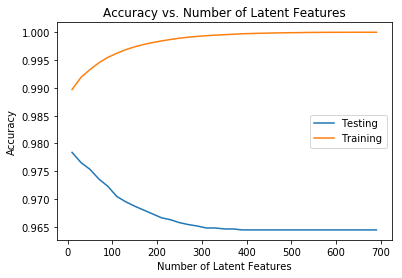

In [97]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_train_errs = []
sum_test_errs = []
F_scores = []

for k in num_latent_feats:
    # restructure the matrices with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot products
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # find F1_score:
    
    f_score = f1_score(user_item_test_subset, user_item_test_est, average = "weighted")
    
    F_scores.append(f_score)
    
    # compute errors for each of the predictions to actual values
    train_diffs = np.subtract(user_item_train, user_item_train_est)
    test_diffs = np.subtract(user_item_test_subset, user_item_test_est)

    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    sum_test_errs.append(test_err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_test_errs)/(user_item_test_subset.shape[0] * user_item_test.shape[1]), label = 'Testing');
plt.plot(num_latent_feats, 1 - np.array(sum_train_errs)/(user_item_train.shape[0] * user_item_test.shape[1]), label = 'Training'); 
plt.legend()

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');



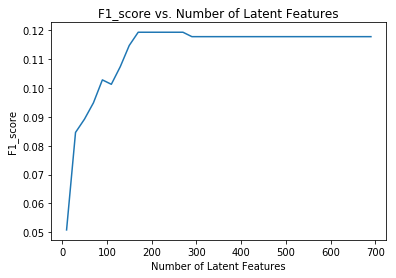

In [98]:
plt.plot(num_latent_feats, F_scores, label = "F1_score")
plt.xlabel('Number of Latent Features');
plt.ylabel('F1_score');
plt.title('F1_score vs. Number of Latent Features');



In [99]:
s_test_new, u_test_new, vt_test_new = np.diag(s_test[:10]), u_test[:, :10], vt_test[:10, :]

In [100]:
user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))

In [101]:
f1_score(user_item_test_subset, user_item_test_est, average = "weighted")

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.050797291393621671

In [102]:
user_item_test

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
user_item_test_est.shape

(20, 574)

### <a class="anchor" id="Matrix-Fact">Part V: Conclusion</a>

6. This model acheived nearly 97% accuracy for predicting whether a user in the testing data set will interact with an article based on nearly 700 articles to choose from. However, the accuracy does not really say much because of "Binary Class Imabalance". There are a great imbalance between the articles not read represented by '0' than articles read represented by '1' for each user, therefore predicting all '0's would still produce a very high accuracy. To better understand how well the model performs it makes more sense to look at the F-score. The plot of the F-score shows that the model is optimized for k latent features having a value somewhere between 150-275, in this range the F-score still is not very impressive, only about 0.12. Nonetheless this information could be useful in making some extra recommendations that the users may like. Further analysis such as an A/B test could be conducted at this point where the users are split into two groups, one group receives recommendations and the other does not and then the relative activity of each group is examined to see if the group that got the recommendations spends more time reading more articles. 

In [106]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0

Attributes: The following 'GitHub' repo was looked at as a reference for part IV, where the U, S, V, matrices were split into training and testing matrices. 

https://github.com/mrinal1704/Recommendation-Engine-with-IBM/blob/master/Recommendation%20engine/Recommendations_with_IBM.ipynb